# Forecasting Mexican oil production using Deep Learning Techniques

This is a practice notebook, but important to understand conventional oil production from PEMEX, Mexico’s state-owned oil company. It is based on conventional oil production since is not considering additional sources such as condensanted oil. 

## Introduction

The production of hydrocarbons remains a critical topic for various types of analysis, as it is closely tied to several key industries such as energy, plastics, and automotive. Nonetheless, although several approaches have been developed to reduce reliance on this essential resource for energy generation—such as renewable sources including wind, solar, and geothermal—in many countries, like Mexico, hydrocarbons are still considered a strategic asset that supports numerous core productive sectors.

Hence, it is important to understand the behavior of hydrocarbon production in order to analyze its impact on various aspects of a country, such as energy generation or even the financial health of the state-owned company responsible for extracting these resources—as is the case with the selected company, PEMEX. Several factors can affect oil production, such as the depletion of underground reservoirs due to ongoing exploitation, the lack of investment in the exploration and drilling of new potential reservoir locations, among others.

In petroleum reservoirs, hydrocarbons can be found in either gas or liquid physical states, gas and oil, respectively. These reservoirs also contain water, which typically accumulates at the bottom due to differences in density. The presence of hydrocarbons in different physical states is caused by the high pressures and temperatures within the underground reservoirs, which are governed by conditions such as the bubble point pressure.
As a result, oil can be extracted from petroleum reservoirs in two ways:
- Conventional extraction, oil in its liquid form.
- Condensate recovery , when gas is brought to the surface and subjected to lower pressures and temperatures.

Moreover, hydrocarbon production is commonly classified as onshore or offshore, that is, oil produced on land or from the seabed, respectively. Furthermore, offshore oil production can also be categorized as deep water or shallow water, depending on how far from the shore the oil is extracted. Depending on a country’s reservoir conditions, these sources contribute differently to overall production. Additionally, deepwater reservoirs are typically among the last to be developed, and therefore tend to be less depleted, especially when compared to shallow water fields. In many cases, due to the high costs associated with deepwater oil production, it is not directly undertaken by state-owned companies, but rather through concessions granted to private industries, and therefore, their production data is not always publicly available.


## Objective

The main goal of this notebook is to implement forecasting techniques based on deep learning approaches to predict the potential future oil production of the selected company. This analysis assumes that current conditions remain unchanged, meaning no significant new investments or discoveries of major reserves are made. Similarly, external factors such as oil prices may influence future production levels, as higher prices can incentivize increased output. However, more aggressive recovery methods—such as gas injection (e.g., nitrogen) or techniques like fracking—are often used to artificially increase production, but relevant data for these strategies is not available and therefore they are not considered in this analysis.

Nevertheless, additional analyses could be conducted in the future using complementary data, such as correlations with historical oil prices, nitrogen injection activities, or investment in exploration and drilling for the aforementioned company.


## Exploratory Data Analysis

### Importing Libraries and Loadind Available Data

#### Importing Libraries

This analysis relies on libraries such as pandas, NumPy, SciPy, and TensorFlow for data processing and modeling, while Matplotlib and Seaborn are used to create visualizations of the results and insights obtained.

In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from Functions import Generating_Predictions, Plotting_Training_Losses, Validation_Prediction
from Functions import Generating_datasets, Future_Predictions

%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Sorry, no GPU for you...")

We got a GPU


#### Loading Data

The data used for this development was obtained from the Mexican National Hydrocarbons Commission ([CNIH](https://sih.hidrocarburos.gob.mx/))  

In [3]:
path = os.path.join(os.getcwd(), 'Data', 'ProduccionHistoriaPemex.csv')
df = pd.read_csv(path, index_col=0).T
df.head()

,HIDROCARBUROS LIQUIDOS (MBD),AGUAS SOMERAS,TERRESTRE,PETROLEO (MBD),AGUAS SOMERAS,TERRESTRE,CONDENSADO (MBD),AGUAS SOMERAS,TERRESTRE,GAS (MMPCD),...,TERRESTRE,GAS NO ASOCIADO (MMPCD),AGUAS SOMERAS,TERRESTRE,NITROGENO (MMPCD),AGUAS SOMERAS,TERRESTRE,AGUA (MBD),AGUAS SOMERAS,TERRESTRE
1960/ENE,262.0,NaN,262.0,262.0,NaN,262.0,0.0,NaN,NaN,885.7,...,295.9,589.8,NaN,589.8,0.0,NaN,NaN,0.0,NaN,NaN
1960/FEB,261.8,0.2,261.6,261.8,0.2,261.6,0.0,NaN,NaN,898.2,...,293.7,604.5,NaN,604.5,0.0,NaN,NaN,0.0,NaN,NaN
1960/MAR,270.2,0.4,269.8,270.2,0.4,269.8,0.0,NaN,NaN,900.6,...,299.1,601.4,NaN,601.4,0.0,NaN,NaN,0.0,NaN,NaN
1960/ABR,251.5,0.8,250.7,251.5,0.8,250.7,0.0,NaN,NaN,886.6,...,291.3,595.0,NaN,595.0,0.0,NaN,NaN,0.0,NaN,NaN
1960/MAY,263.8,1.5,262.3,263.8,1.5,262.3,0.0,NaN,NaN,889.4,...,304.6,584.2,NaN,584.2,0.0,NaN,NaN,0.0,NaN,NaN


### Cleaning and preprocessing the loaded data

In [4]:
# Standardising months names for its processing
dates_dict = {'ENE':'01','FEB':'02','MAR':'03','ABR':'04','MAY':'05','JUN':'06','JUL':'07','AGO':'08','SEP':'09','OCT':'10','NOV':'11','DIC':'12'}
for item in dates_dict.items():
    df.index = df.index.str.replace(item[0], item[1])
    
# Selecting columns or features associated with the conventional production of oil
df =  df.iloc[:,3:6]

# Renaming columns to a cleaner, standardized format (no caps or spaces)
new_cols_names = ['Petroleo_MBD', 'Aguas_Someras', 'Terrestre']
new_cols = {}
for i, col in enumerate(df.columns):
    new_cols[col] = new_cols_names[i]
    
# Cleaning up the dataframe: fixing date formats and setting column order
df.loc[:, 'Fecha'] = pd.to_datetime(df.index, format = '%Y/%m')
df.rename(columns=new_cols, inplace=True)
df = df[['Fecha']+new_cols_names]
df.reset_index(inplace = True, drop = True)

# Displaying Dataframe Sample
df.head(12)

,Fecha,Petroleo_MBD,Aguas_Someras,Terrestre
0,1960-01-01,262.0,NaN,262.0
1,1960-02-01,261.8,0.2,261.6
2,1960-03-01,270.2,0.4,269.8
3,1960-04-01,251.5,0.8,250.7
4,1960-05-01,263.8,1.5,262.3
5,1960-06-01,275.4,1.4,273.9
6,1960-07-01,279.8,1.5,278.3
7,1960-08-01,288.7,2.1,286.6
8,1960-09-01,287.6,1.5,286.1
9,1960-10-01,267.5,1.6,265.9


- ***Removing or Imputing Null Values***

In [5]:
# Displaying the number of NaN values for each selected feature
display(pd.DataFrame(df.isnull().sum(axis=0), columns=['Total NaN Values']).T)

n_missing = df.isnull().sum().sum()
print(f"Total missing values dropped: {n_missing}")

# Dropping rows with NaN values (only 1 found)
df.dropna(inplace=True)

,Fecha,Petroleo_MBD,Aguas_Someras,Terrestre
Total NaN Values,0,0,1,0


Total missing values dropped: 1


#### Visualizing the Loaded and Cleaned Data

The following figure shows the loaded and cleaned data, representing oil production in millions of barrels per day, along with its decomposition into onshore (Terrestre) and shallow water (Aguas Someras) sources. It can be observed that in the early years of the historical series, most of the production came from onshore fields. However, after 1979, the majority of production shifted to shallow waters, likely due to the discovery of major offshore reserves such as the Cantarell field.

Additionally, a sustained decline in production can be seen beginning around 2004, possibly due to the natural depletion of Cantarell and the lack of new large-scale discoveries or enhanced recovery methods during that period.

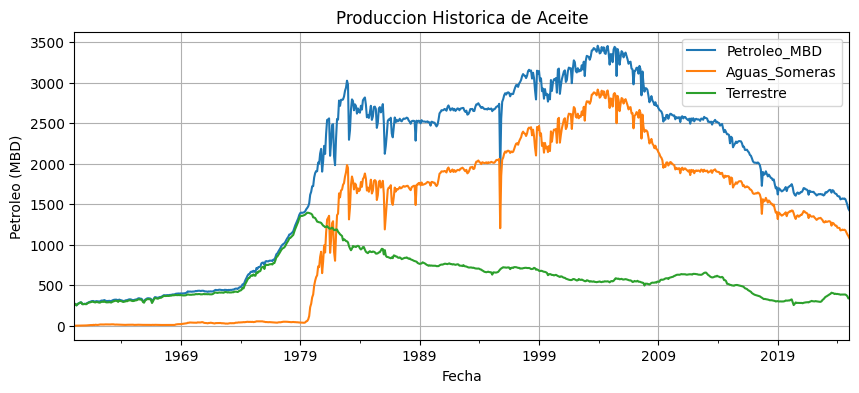

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,4))  
df.plot(x='Fecha', y='Petroleo_MBD', ax=ax, ylabel='Petroleo (MBD)', title='Produccion Historica de Aceite')
df.plot(x='Fecha', y='Aguas_Someras', ax=ax)
df.plot(x='Fecha', y='Terrestre', ax=ax);
plt.grid()

### Analyzing the Production of Oil

The first analysis to be conducted involves the use of histograms to explore the statistical distribution of the selected features in the dataset.
This step helps assess how the data should be processed, for example, identifying and removing anomalies that may affect predictions, or determining the appropriate standardization technique to apply.

- ***Statistical distribution of oil production***

The following figure shows the statistical distribution of values for the different features related to oil production. It can be observed that these values do not follow a normal distribution, which is important to consider when selecting appropriate methods for detecting and removing anomalies.

It is also worth mentioning that the observed behaviors may be linked to the different geological characteristics of the reservoirs from which the oil is produced. While individual reservoirs might follow approximately Gaussian production patterns, the aggregated total reflects the combination of multiple sources, resulting in more complex, multimodal distributions.

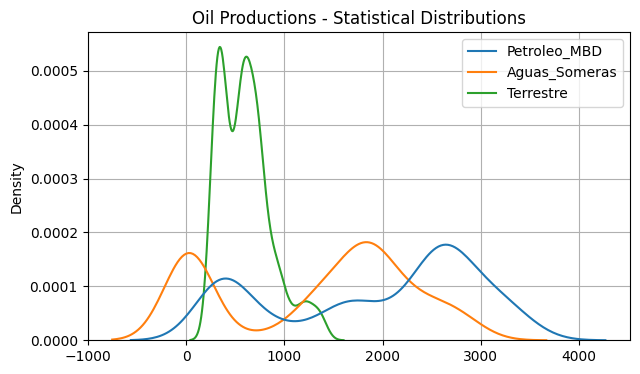

In [7]:
fig, ax = plt.subplots(1,1, figsize=(7,4))  
sns.kdeplot(df, ax=ax)
ax.set_title('Oil Productions - Statistical Distributions')
plt.grid()

- ***Detecting and Removing Outliers***

The next step in the analysis involves detecting and removing anomalies. This is important, as extreme values, either too large or too small compared to the majority of observations, can negatively affect prediction performance. Since it was previously observed that the data does not follow a normal distribution, its mean and variance are not reliable representations of its overall behavior.

Therefore, using the interquartile range (IQR) is more appropriate than relying on the z-score when applying simple approaches for anomaly detection and removal, as presented next:

In [8]:
# Calculating the first (Q1) and third (Q3) quartiles of oil production
q1 = df["Petroleo_MBD"].quantile(0.25)
q3 = df["Petroleo_MBD"].quantile(0.75)

# Interquartile range (IQR)
iqr = q3 - q1

# Defining lower and upper bounds for outlier detection (1.5*IQR rule)
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Flagging outliers in oil production using IQR method
df["outlier_iqr"] = (df["Petroleo_MBD"] < lower) | (df["Petroleo_MBD"] > upper)
print(f"Total outliers detected: {df['outlier_iqr'].sum()}")

Total outliers detected: 0


- ***Boxplots Visualization***

The following figure shows the boxplot representations of the oil production data, including values that fall outside the whiskers and are considered outliers under the implemented approach. Additionally, it can be observed that shallow water production tends to be mostly composed of values below the median, which is expected, as the majority of its values fall under 2,000 MBD. In contrast, the onshore (land) production shows the presence of outliers, which are likely related to unusually high production levels recorded at the beginning of the historical series.

This may be due to the strategic importance of onshore production before the discovery of Cantarell, which probably shifted operational focus toward offshore extraction—making the previous high onshore production appear anomalous in the broader context of the full time series.

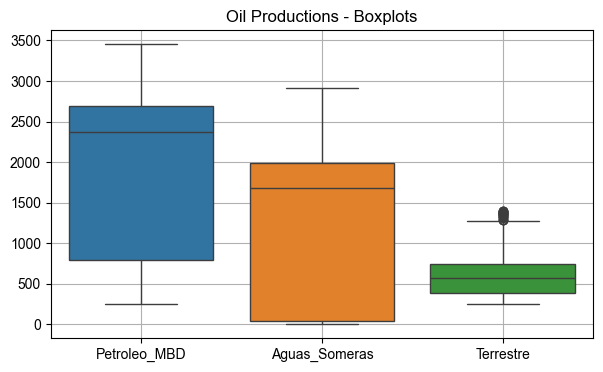

In [9]:
fig, ax = plt.subplots(1,1, figsize=(7,4))  
sns.set_style("whitegrid") 
sns.boxplot(df[df.columns[:-1]], ax=ax) 
ax.set_title('Oil Productions - Boxplots')
plt.grid()

### Feature Engineering

The following cell defines the variables (or predictors) used to forecast conventional oil production using deep learning techniques. As previously observed, most of the production, especially in recent years, is strongly linked to shallow water output, which is also highly correlated with overall conventional production. Thus, the forecasting problem behaves like a univariate system, as shallow water production alone provides a strong representation of the target variable.

Based on this, we will use only the Fecha and Petroleo_MBD variables to build our predictive model or regressor. However, since it is important to properly capture the seasonal effects of oil production, we must transform the date variable to reflect its periodic nature. This is especially relevant when working with data that spans several years, where seasonal behavior is expected to be present. 

For this reasons, we apply sine and cosine transformations to represent the month of the year in a cyclic manner, helping reduce potential bias between months and improving the model’s ability to generalize, as presented next:

In [10]:
# Extracting the months components from the date variable and transforming using sine and cosine functions
df.loc[:, 'month_sin'] = np.sin(2 * np.pi * df.Fecha.dt.month / 12)              
df.loc[:, 'month_cos'] = np.cos(2 * np.pi * df.Fecha.dt.month / 12)  

# Selecting features to forecast conventional oil production
df = df[['Fecha', 'Petroleo_MBD', 'month_sin', 'month_cos']]
df.reset_index(inplace = True, drop = True)
df.head()

,Fecha,Petroleo_MBD,month_sin,month_cos
0,1960-02-01,261.8,8.660254e-01,5.000000e-01
1,1960-03-01,270.2,1.000000e+00,6.123234e-17
2,1960-04-01,251.5,8.660254e-01,-5.000000e-01
3,1960-05-01,263.8,5.000000e-01,-8.660254e-01
4,1960-06-01,275.4,1.224647e-16,-1.000000e+00


## Forecasting Conventional Oil Production Using Deep Learning Techniques

In this section, CNN and RNN network structures are used to forecast conventional oil production, based on the processed dataset generated in the previous section. It is expected that RNN-based approaches, particularly those using LSTM and GRU units, will outperform CNNs in predictive performance due to their ability to retain memory and capture temporal dependencies. However, CNNs offer the advantage of spatial filtering, which can uncover local patterns and structures within the input sequences—even in the absence of explicit memory mechanisms.

#### Normalizing Oil Production to reduce Bias

It is important to normalize the data used for forecasting in order to reduce potential biases. Since we are working with periodically transformed months (using sine and cosine), whose values range from -1 to 1, and oil production values are significantly larger, normalization is required. This ensures that the seasonal features have a meaningful impact on the model, allowing the predictor to properly consider seasonal effects in conventional oil production.

In [11]:
# Creating the normalizer, in this case based on the scikitlearn MinMaxScaler
scaler = MinMaxScaler()

# Normalizing the conventional oil production
df["scaled_oil"] = scaler.fit_transform(df[["Petroleo_MBD"]])

C:\Users\Tecuhtli\AppData\Local\Temp\ipykernel_55748\1645124877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["scaled_oil"] = scaler.fit_transform(df[["Petroleo_MBD"]])


#### Generating Tensorflow Tensors for the Forecasting

Deep learning approaches rely on the processing of input data be fed into network structures such as the CNN and RNN architectures used in this notebook. As a result, it is necessary to convert both the target variable (to be forecasted) and the predictors into Tensors. It is also important to consider that our goal is to forecast unseen future values based on a fixed number of previous samples. This must be taken into account when generating the input tensors for the mentioned network structures.

To address this, we apply a sliding window approach, where each sample consists of n consecutive time steps used to predict the next one. The window then shifts forward, using the next n samples to predict the next value, repeating this process in a loop over the entire dataset. As a result, we generate two tensors per window position: one composed of the n input samples (used for prediction), and one composed of the target value to be predicted.

In [12]:
# Selecting features for prediction (scaled target + cyclical month encoding)
features = df[["scaled_oil", "month_sin", "month_cos"]].values

# Function to implement the sliding window approach
def create_multivariate_windows(data, window_size=12):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])  # From i-window_size to i-1
        y.append(data[i][0])               # Predicting 'scaled' at time i
    return np.array(X), np.array(y)

# Creating datasets: input sequences and target values
X, y = create_multivariate_windows(features, window_size=4)

# Converting to TensorFlow tensors
X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

# Displaying tensor shapes
print("X shape:", X_tensor.shape)  # (samples, time_steps, features)
print("y shape:", y_tensor.shape)  # (samples,)

X shape: (776, 4, 3)
y shape: (776,)


#### Generating Training and Test Datasets for Predictor Development and Validation

Once the tensors to be used as inputs for the deep learning techniques have been generated, it is necessary to split them into two additional datasets: a training set and a validation (or test) set. These datasets are essential for allowing the model to learn the relationship between n previous samples and the next time step, enabling it to accurately forecast future values of conventional oil production.

In [13]:
# Defining the number of elements to split the tensors into training and validation datasets
split = int(len(X_tensor) * 0.8)

# Generating the training and validation datasets
X_train, X_val = X_tensor[:split], X_tensor[split:]
y_train, y_val = y_tensor[:split], y_tensor[split:]

### Forecasting Conventional Oil Production using CNNs

The first deep learning approach used for forecasting conventional oil production is based on Convolutional Neural Networks (CNNs).
CNNs are widely used in image processing due to their spatial filtering capabilities, which allow the network to identify patterns and extract relevant features from structured inputs.

In the context of time series, this spatial property enables the network to capture local temporal patterns across continuous time samples—such as trends of increasing or decreasing values that follow specific behaviors.
Depending on the selected parameters (e.g., kernel size and stride), the network can detect these patterns over varying time intervals, helping it identify relevant dynamics in the data.


#### Creating the CNN Architecture for Forecasting

The CNN architecture used to forecast conventional oil production is composed of Conv1D, MaxPooling1D, Dropout, Flatten, and Dense layers from Keras.
The Conv1D layers perform the convolution operations, and in this case, two consecutive Conv1D layers are used to extract patterns from the input time series. These are followed by a MaxPooling1D layer, which helps reduce dimensionality and smooth out noise by downsampling the output of the convolutions. After the convolutional blocks, a Flatten layer is used to convert the multi-dimensional output into a 1D vector, making it suitable for a fully connected Dense layer. This final Dense layer uses the learned patterns to predict the next value in the oil production sequence.

Additionally, Dropout layers are included throughout the architecture to randomly discard a fraction of neurons during training, which helps prevent overfitting and improves the model’s generalization ability. The complete model architecture is shown below:

In [14]:
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(4, 3)),
    #Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(70, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Predicción de PETROLEO
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             224       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 70)                2310      
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                        

#### Compiling and Training the Model

Before training, the model architecture must be compiled so that TensorFlow can properly optimize it.
During compilation, we define both the loss function—which tells the model how far off its predictions are—and the optimizer, which determines how the model updates its weights during training.

Once compiled, the model can be trained using the .fit() method, as shown below:

In [15]:
# Compiling the model
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Definir callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tqdm_bar = TqdmCallback(verbose=1)

# Entrenamiento con ambos callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, tqdm_bar],
    verbose=0  # Muy importante: desactiva verbose para usar tqdm
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

#### Analyzing the Training Losses

The following figures show the results obtained during the training process of the designed CNN architecture, using MSE and MAE as evaluation metrics for both training and validation datasets. It can be observed that the model is learning effectively from the training data, successfully capturing patterns to forecast conventional oil production.

Although the decrease in validation loss is not as steep as in the training case, it still shows a consistent downward trend. This indicates that the model is not just memorizing the training data, but also generalizing well to unseen data, learning to relate the input features to future production values.

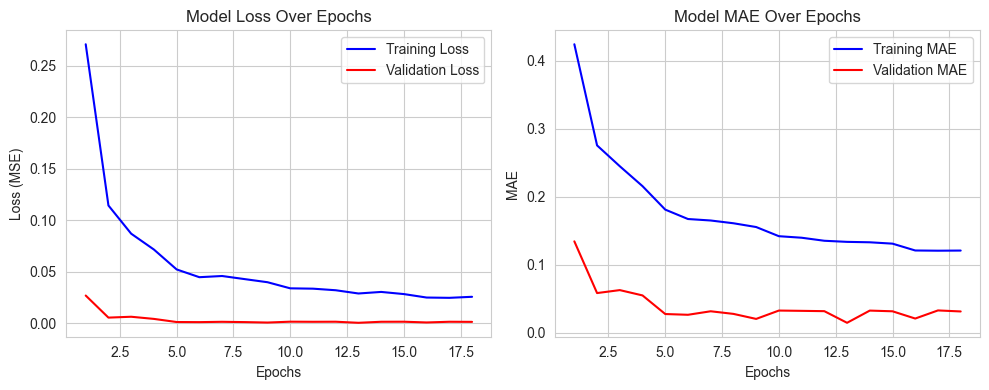

In [16]:
Plotting_Training_Losses(history)

#### Forecasting Conventional Oil Production Using the Validation Dataset

To further evaluate the trained model, it is used to forecast the y_set values from the validation dataset. As shown in the following figure, the model’s predictions closely follow the behavior of actual conventional oil production, capturing both the general trend and seasonal patterns. Although the predicted values are slightly noisier, they exhibit minimal bias, which reflects the low training and validation loss achieved during model optimization. Nonetheless, evaluating the model on real data is essential to better understand its limitations and potential areas for improvement.

5/5 [==============================] - 0s 11ms/step


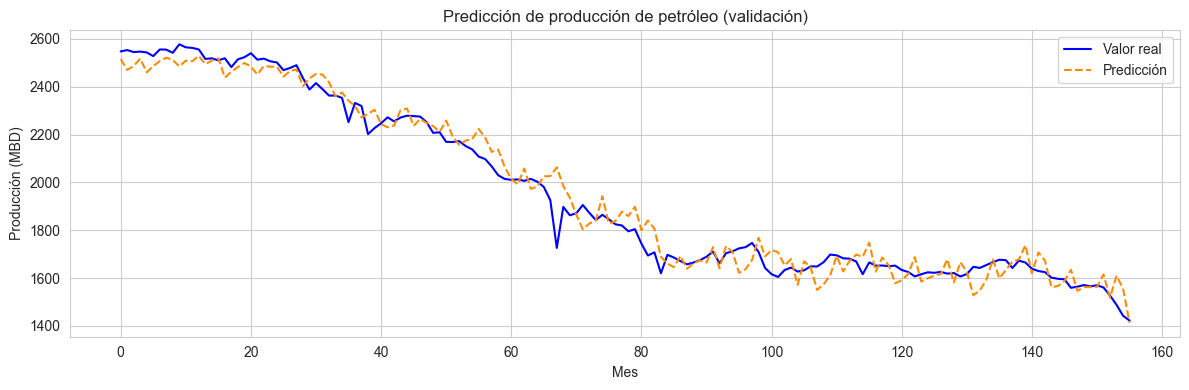

In [17]:
# Generating Predictions
y_pred = model.predict(X_val)

# Rescaling predictions to be in the same range of values than real oil production
y_pred_rescaled = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_val_rescaled = scaler.inverse_transform(np.array(y_val).reshape(-1, 1))
                                         
# Plotting
plt.figure(figsize=(12, 4))
plt.plot(y_val_rescaled, label='Valor real', color='blue')
plt.plot(y_pred_rescaled, label='Predicción', linestyle='--', color='darkorange')
plt.title('Predicción de producción de petróleo (validación)')
plt.xlabel('Mes')
plt.ylabel('Producción (MBD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Forecasting conventional oil production for the rest of 2025

Once trained and validated, the model can be used to forecast conventional oil production for future, unseen dates. This is done using a strategy known as a multistep approach, where the previous n values are used to predict the next one. The predicted value is then included in the subsequent input window to generate the following prediction, and this process continues recursively, allowing the model to simulate extended time horizons step by step.

Thus, by following this approach, the model is used to forecast conventional oil production for the remaining months of 2025, as shown in the following results.

- ***Predicting conventional oil production for the rest of 2025***

In [18]:
# Number of months to forecast (e.g., remaining months of 2025)
n_future_steps = 11
window_size = 4  # Same as used during dataset creation and training

# Selecting the last available window from the validation set
last_window = X_val[-1].numpy().copy()  # Shape: (4, 3) → [scaled, month_sin, month_cos]

# List to store the predicted values (scaled)
future_preds = []

# Forecasting conventional oil production using multistep autoregression
for i in range(n_future_steps):

    # Creating the input tensor from the current window
    input_tensor = tf.convert_to_tensor([last_window], dtype=tf.float32)

    # Predicting the next production value (scaled)
    pred = model.predict(input_tensor, verbose=0)[0][0]
    future_preds.append(pred)

    # Generating sine/cosine features for the next month
    next_month_index = (i + 1 + X_val.shape[0]) % 12
    next_month_sin = np.sin(2 * np.pi * next_month_index / 12)
    next_month_cos = np.cos(2 * np.pi * next_month_index / 12)

    # Creating the next entry [scaled_pred, sin(month), cos(month)]
    next_entry = [pred, next_month_sin, next_month_cos]

    # Updating the window (sliding forward)
    last_window = np.vstack([last_window[1:], next_entry])

# Inversely scaling the predictions using the trained MinMaxScaler
future_preds_rescaled = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

- ***Visualizing conventional oil production predictions for 2025***

In the folloeing Figure are presented forecasted conventional oil production for 2025 using the trained CNN model. The blue points represent actual production values through the end of 2024, while the red points correspond to predicted values for each month of 2025. The model successfully continues the observed trend and captures cyclical variations, showing its ability to generalize and simulate production under the current conditions.

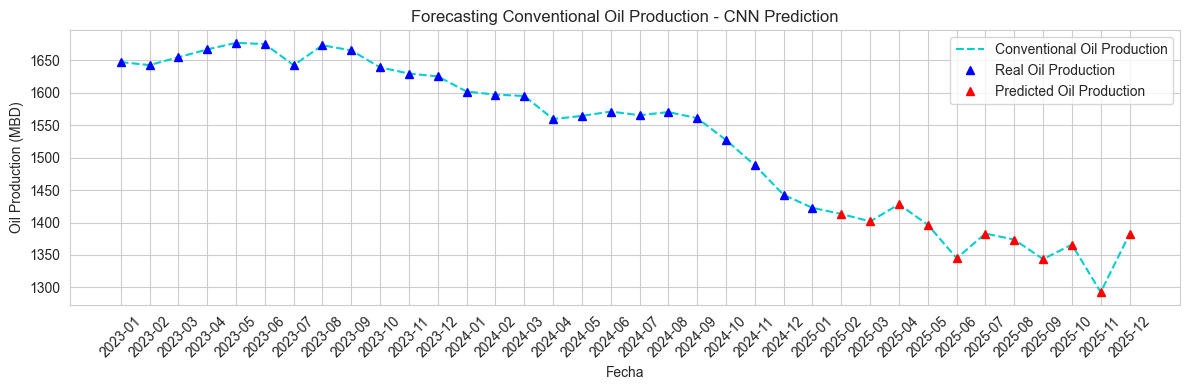

In [19]:
# Creating list containing all conventional oil productio values
oil_prod = df.Petroleo_MBD.tolist()[-25:]+future_preds_rescaled.tolist()

# Producción real (últimos 50 del set de validación)
real_prod = df.Petroleo_MBD.tolist()[-25:]
pred_prod = future_preds_rescaled.tolist()

dates = [df.loc[df.shape[0]-1, 'Fecha']]
for n in range(11):
    dates.append(dates[-1]+pd.DateOffset(months=1))
Fechas = df.Fecha.tolist()[-25:-1] + dates

# Plotting predicted conventional oil production
fig, ax = plt.subplots(1,1, figsize=(12,4)) 
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas], oil_prod, color='darkturquoise', linestyle='--', label='Conventional Oil Production')
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][:-11], real_prod, color='blue', linestyle='', marker='^', label='Real Oil Production')
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][-11:], pred_prod, color='red', linestyle='', marker='^', label='Predicted Oil Production')
ax.set_xlabel('Fecha')
ax.set_ylabel('Oil Production (MBD)')
ax.set_title('Forecasting Conventional Oil Production - CNN Prediction')
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.tight_layout()


#### Confidence Intervals for the Model's Predicted Values

In this subsection, the variability associated with the model’s predictions is presented. This variability arises from the uncertainty inherent to the model itself, especially when using previous predictions to estimate future values. Any small error in an early prediction is cumulative and propagates across subsequent forecasting steps, amplifying the uncertainty.

Additionally, the lack of external predictors affects the model’s ability to capture relationships influenced by factors beyond conventional oil production. These include elements such as global oil prices, reservoir depletion, or investment in exploration, factors that cannot be inferred solely from production data.

To estimate the confidence intervals, the *Monte Carlo Dropout* technique was used. This method combines Monte Carlo sampling with dropout layers activated during inference, effectively simulating multiple models with slightly different internal configurations. The predictions from these simulations are then used to estimate the *mean forecast* and the *variability* (i.e., confidence interval), offering a more realistic sense of the model’s uncertainty during prediction.

Thus, the Monte Carlo Dropout approach was applied to forecast oil production for the remaining months of 2025, simulating 100 possible outcomes from 100 model instances with slightly different internal configurations. This technique allows the estimation of the expected variability in the predictions and the corresponding confidence intervals, providing a more complete picture of the model’s uncertainty. These results are illustrated in the following figure.

- ***Creating 100 production inferences for the remaining months of 2025***

In [20]:
mean_rescaled, lower_rescaled, upper_rescaled = Generating_Predictions(model, X_val, 100, 11, scaler)

Generating forecasts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:59<00:00, 10.85s/it]


- ***Confidence Intervals for 2025 Predictions***

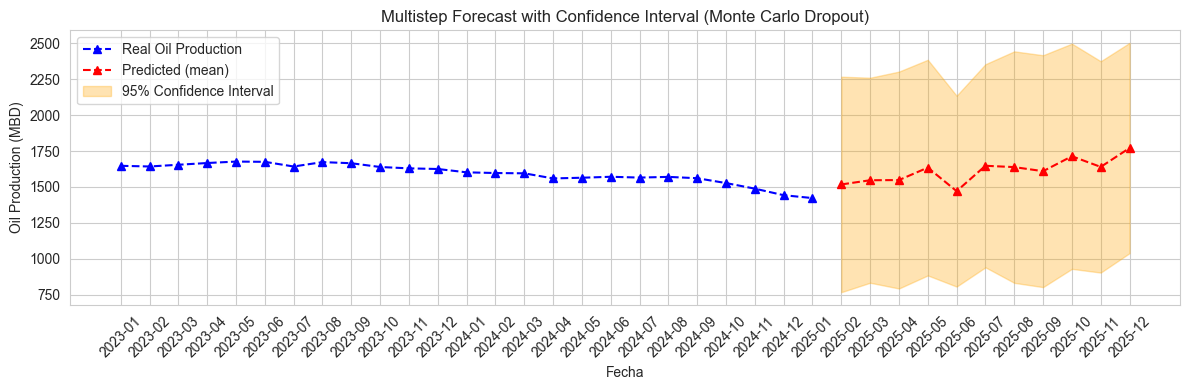

In [21]:
# Plotting predicted conventional oil production
fig, ax = plt.subplots(1,1, figsize=(12,4)) 
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][:-11], real_prod, color='blue', linestyle='--', marker='^', label='Real Oil Production')
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][-11:], mean_rescaled, label='Predicted (mean)', linestyle='--', marker='^', color='red')
ax.fill_between([fecha.strftime('%Y-%m') for fecha in Fechas][-11:], lower_rescaled, upper_rescaled,
                color='orange', alpha=0.3, label='95% Confidence Interval')
ax.set_xlabel('Fecha')
ax.set_ylabel('Oil Production (MBD)')
ax.set_title('Multistep Forecast with Confidence Interval (Monte Carlo Dropout)')
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.tight_layout()

### Forecasting Conventional Oil Production using RNNs

The second deep learning approach implemented relies on the use of *Recurrent Neural Networks (RNNs)*, which are particularly suitable for handling temporal or sequential data due to their memory capabilities. These models retain information from previous time steps to make informed predictions about future values.

Two popular RNN cell architectures are explored in this section: *Long Short-Term Memory (LSTM)* and *Gated Recurrent Units (GRU)*. Each has distinct characteristics that can be beneficial for forecasting conventional oil production, especially in the presence of long-term dependencies or noisy trends. The objective is to evaluate and compare the performance of these RNN-based models against the previously tested CNN-based model, focusing on their accuracy and generalization capabilities for short- and medium-term forecasting.

#### RNN Architecture Based on LSTM

The first RNN-based forecasting model relies on *Long Short-Term Memory (LSTM)* cells. In general, LSTMs are considered more robust than GRU-based architectures, especially when dealing with complex temporal dependencies. However, this comes at the cost of higher computational requirements and an increased risk of overfitting due to their larger number of parameters and more intricate internal mechanisms.

Despite their complexity, LSTMs are often better suited for modeling *long-term patterns* in time series data, making them a strong choice for forecasting problems where capturing historical context is essential.

- ***Preparing the training and validation sets***

In [22]:
X_train, y_train, X_val, y_val = Generating_datasets(df, 12, .8)

X shape: (768, 12, 3)
y shape: (768,)


- ***Creating the RNN Architecture for Forecasting***

The RNN architecture based on LSTM cells is composed of two LSTM layers, followed by Dropout layers with a 20% rate to reduce potential overfitting, and a Dense layer for the final prediction. Unlike the CNN-based architecture (which uses Conv1D layers), a Flatten layer is not required, since the LSTM layer already outputs a tensor compatible with the Dense layer.

In [23]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            17408     
                                                                 
 dropout_2 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


- ***Compiling and Training the Model***

In [24]:
# Compiling the model
optimizer = Adam(learning_rate=0.0002)  # Ejemplo: más pequeño que el default

lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, TqdmCallback(verbose=1)],
    verbose=0
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

- ***Analyzing the Training Losses***

The following figure shows the evolution of training and validation losses during the training process of the LSTM-based model. It can be observed that both loss metrics—MSE and MAE—decrease steadily, which indicates that the model is effectively learning to predict values for both the training and validation datasets.

Although the training performance appears better compared to the previous convolutional-based model, the validation losses still exhibit some variability. This suggests that while the model generalizes relatively well, there is room for improvement in terms of stability and robustness on unseen data.

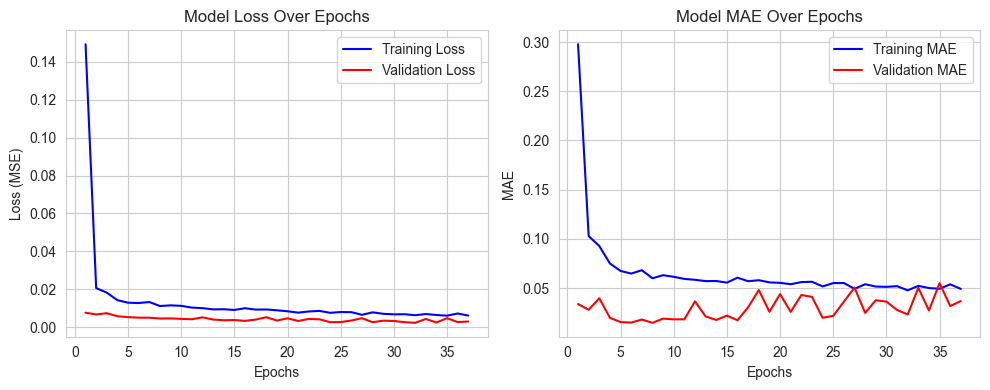

In [25]:
Plotting_Training_Losses(history)

- ***Forecasting Conventional Oil Production Using the Validation Dataset***

The following figure presents the predictions generated by the LSTM-based model on the validation dataset. It can be observed that the predicted values closely follow the actual oil production, capturing the overall trend with fewer fluctuations compared to the CNN-based model. While there are still some discrepancies between the real and predicted values, these differences are relatively minor and remain within a reasonable range, as shown in the figure.

5/5 [==============================] - 1s 6ms/step


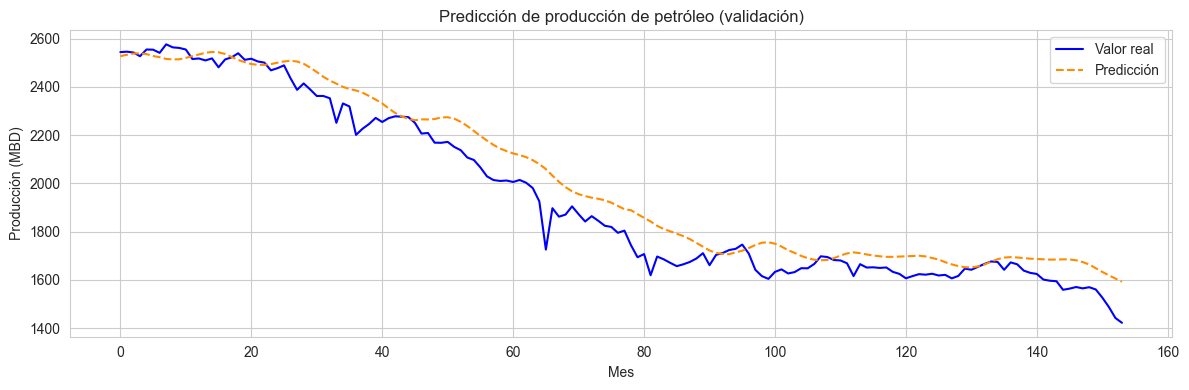

In [26]:
Validation_Prediction(lstm_model, X_val, y_val, scaler)

- ***Visualizing Conventional Oil Production Predictions for 2025***

The following figure presents the forecasted conventional oil production for 2025 using the trained LSTM-based RNN model. As in the previous CNN-based case, blue markers represent actual production values through the end of 2024, while red markers indicate the predicted monthly values for 2025.

Compared to the CNN model, the LSTM-based predictions follow the historical trend more smoothly and with greater consistency. However, the results may not seem entirely realistic when compared to the previously observed short-term fluctuations in conventional oil production. This behavior might be explained by the use of a sliding window of 12 months during training, which makes the model better suited to capturing long-term patterns rather than short-term variations.

Thus, while the predictions may not immediately reflect sharp month-to-month changes, they likely provide a more stable long-term forecast. In contrast, GRU units—explored in the next section—may offer better performance for capturing shorter-term dynamics in the data.

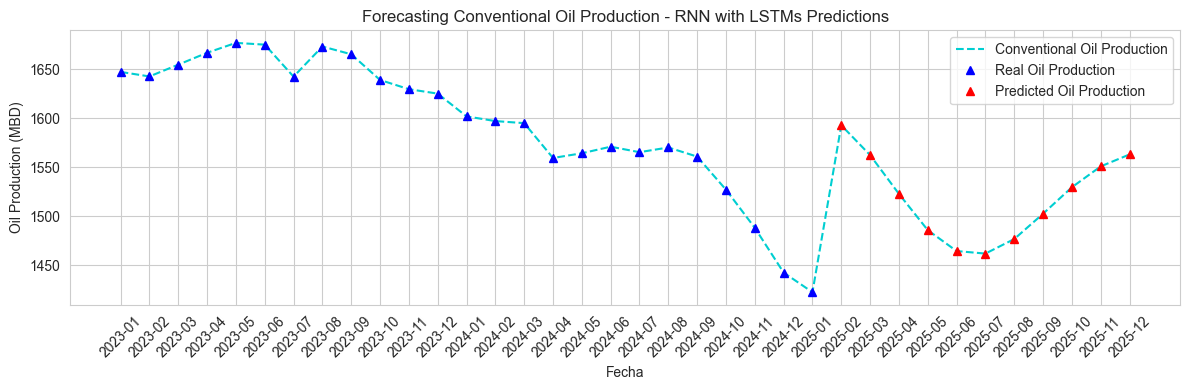

In [27]:
title = 'Forecasting Conventional Oil Production - RNN with LSTMs Predictions'
Future_Predictions(lstm_model, df, X_val, 25, 11, scaler, title, 12)

- ***Confidence Intervals for the Model's Predicted Values***

As shown in the figure, the confidence interval widens as the forecast horizon extends further into the future, reflecting the natural increase in uncertainty when making long-range predictions. This behavior highlights the importance of incorporating uncertainty estimates when interpreting model outputs—especially in scenarios like oil production forecasting, where external factors and unmodeled dynamics can significantly impact the actual outcome.

Generating forecasts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:55<00:00, 15.92s/it]


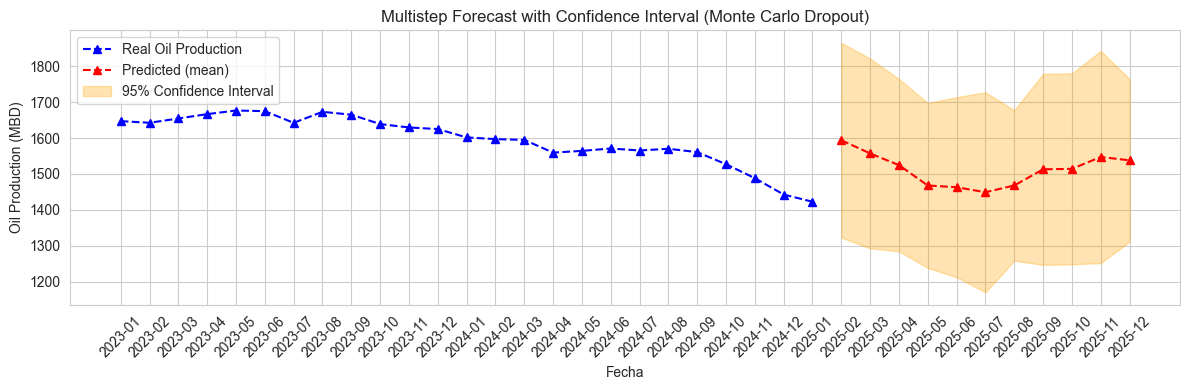

In [28]:
mean_rescaled, lower_rescaled, upper_rescaled = Generating_Predictions(lstm_model, X_val, 100, 11, scaler)

# Plotting predicted conventional oil production
fig, ax = plt.subplots(1,1, figsize=(12,4)) 
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][:-11], real_prod, color='blue', linestyle='--', marker='^', label='Real Oil Production')
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][-11:], mean_rescaled, label='Predicted (mean)', linestyle='--', marker='^', color='red')
ax.fill_between([fecha.strftime('%Y-%m') for fecha in Fechas][-11:], lower_rescaled, upper_rescaled,
                color='orange', alpha=0.3, label='95% Confidence Interval')
ax.set_xlabel('Fecha')
ax.set_ylabel('Oil Production (MBD)')
ax.set_title('Multistep Forecast with Confidence Interval (Monte Carlo Dropout)')
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.tight_layout()

#### RNN Architecture Based on GRUs
The first RNN-based forecasting model relies on *Long Short-Term Memory (LSTM)* cells. In general, LSTMs are considered more robust than GRU-based architectures, especially when dealing with complex temporal dependencies. However, this comes at the cost of higher computational requirements and an increased risk of overfitting due to their larger number of parameters and more intricate internal mechanisms.

Despite their complexity, LSTMs are often better suited for modeling *long-term patterns* in time series data, making them a strong choice for forecasting problems where capturing historical context is essential.

- ***Preparing the training and validation sets***

To train the GRU-based RNN model, it is necessary to modify the tensors used during training. Unlike LSTM cells, GRUs are generally more effective at learning short-term patterns. As a result, using a one-year sliding window, suitable for LSTMs, could hinder the GRU model's ability to generalize properly. Therefore, a smaller sliding window is used to create the training and validation tensors, as shown below:

In [29]:
X_train, y_train, X_val, y_val = Generating_datasets(df, 4, .8)

X shape: (776, 4, 3)
y shape: (776,)


- ***Creating the RNN Architecture for Forecasting***

Once the training and validation tensors have been created, the GRU-based RNN model is defined. The architecture consists of two stacked GRU layers, each followed by a Dropout layer to reduce overfitting. Finally, a Dense layer is used to generate the output predictions. The structure is presented in the following section:

In [30]:
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 64)             13248     
                                                                 
 dropout_4 (Dropout)         (None, 4, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,689
Trainable params: 22,689
Non-trainable params: 0
_________________________________________________________________


- ***Compiling and Training the Model***

In [31]:
# Compilación del modelo
gru_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
# Callback para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo GRU
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, TqdmCallback(verbose=1)],
    verbose=0
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

- ***Analyzing the Training Losses***

As seen in the previous CNN and LSTM models, the GRU-based model is learning effectively, as demonstrated by its performance on both the training and validation datasets for forecasting conventional oil production. Additionally, it can be observed that the model is not overfitting, as the training and validation loss curves behave similarly throughout the training process.

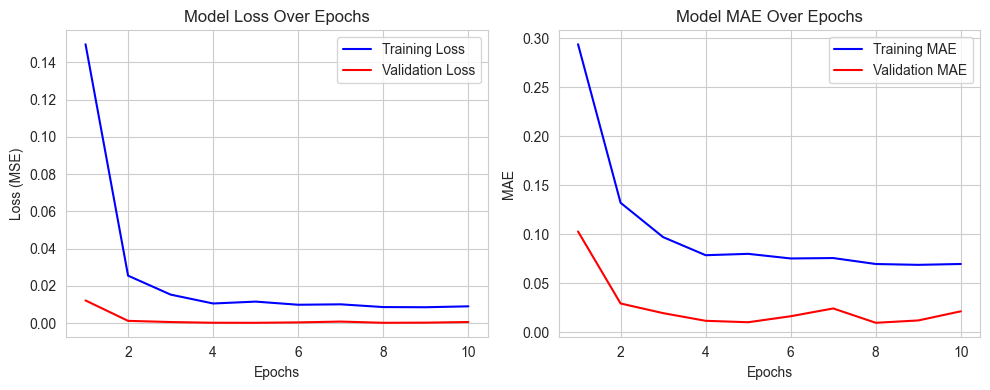

In [32]:
Plotting_Training_Losses(history)

- ***Forecasting Conventional Oil Production Using the Validation Dataset***

The predictions of conventional oil production using the GRU-based model demonstrate better performance compared to the CNN and LSTM models. This is evident in how closely the predicted values follow the real production data, both in terms of magnitude and the general trend over time. The GRU model captures the variations in production more accurately, resulting in a more consistent and realistic forecasting behavior throughout the validation period.

5/5 [==============================] - 2s 9ms/step


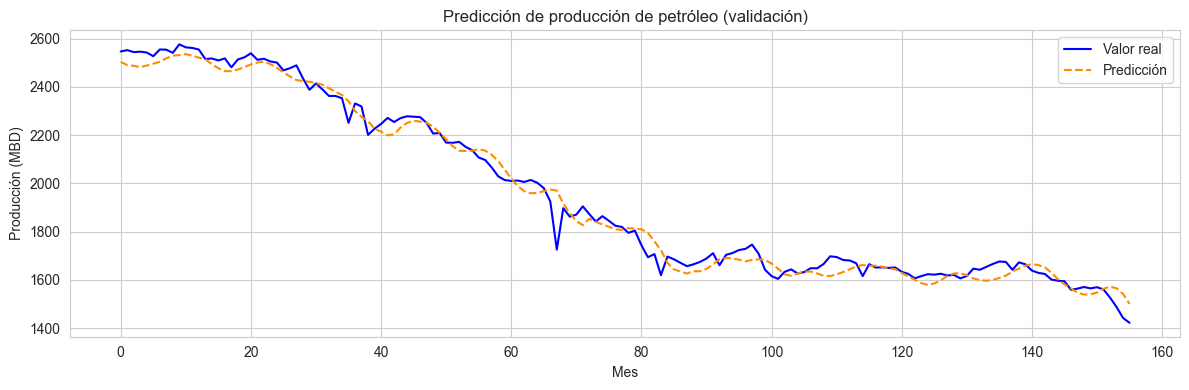

In [33]:
Validation_Prediction(gru_model, X_val, y_val, scaler)

- ***Visualizing Conventional Oil Production Predictions for 2025***

As expected from previous results, the GRU-based model provides predictions that more closely follow the real conventional oil production compared to the two previously trained models. However, it is important to highlight that this model was specifically trained to capture short-term trends, which explains its stronger performance in this context. Nevertheless, for longer-term forecasting, the LSTM-based model may offer better results due to its ability to retain and model longer dependencies in the data.

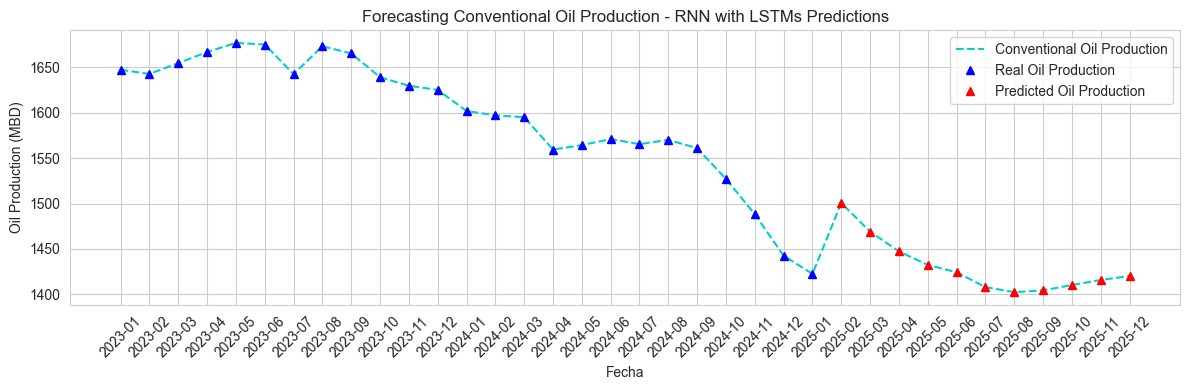

In [34]:
title = 'Forecasting Conventional Oil Production - RNN with LSTMs Predictions'
Future_Predictions(gru_model, df, X_val, 25, 11, scaler, title)

- ***Confidence Intervals for the Model's Predicted Values***

The following figure presents the prediction variability of the GRU-based trained model, which is essential for assessing the reliability of the forecasts. By performing multiple forward passes using the Monte Carlo Dropout technique, we simulate different model configurations to estimate the distribution of possible outcomes. This allows us to calculate the 95% confidence interval for each predicted value. As shown, the model's predictions remain relatively stable, but the widening of the interval over time reflects increasing uncertainty as the model moves further away from the known data. This insight is crucial for decision-making, as it helps quantify the risks associated with longer-term forecasts.

Generating forecasts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:28<00:00, 13.48s/it]


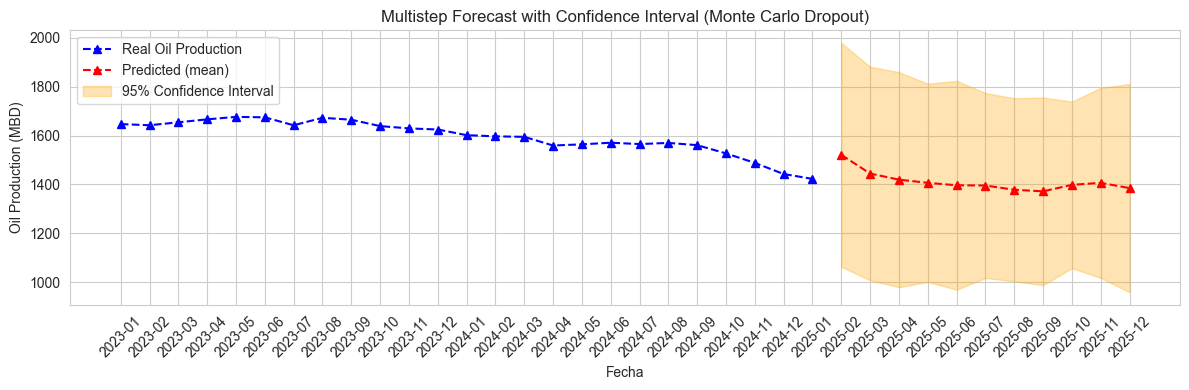

In [35]:
mean_rescaled, lower_rescaled, upper_rescaled = Generating_Predictions(gru_model, X_val, 100, 11, scaler)

# Plotting predicted conventional oil production
fig, ax = plt.subplots(1,1, figsize=(12,4)) 
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][:-11], real_prod, color='blue', linestyle='--', marker='^', label='Real Oil Production')
ax.plot([fecha.strftime('%Y-%m') for fecha in Fechas][-11:], mean_rescaled, label='Predicted (mean)', linestyle='--', marker='^', color='red')
ax.fill_between([fecha.strftime('%Y-%m') for fecha in Fechas][-11:], lower_rescaled, upper_rescaled,
                color='orange', alpha=0.3, label='95% Confidence Interval')
ax.set_xlabel('Fecha')
ax.set_ylabel('Oil Production (MBD)')
ax.set_title('Multistep Forecast with Confidence Interval (Monte Carlo Dropout)')
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.tight_layout()

## Conclusion

After implementing three different deep learning approaches, it can be concluded that forecasting conventional oil production using these techniques is indeed feasible. However, each method presents distinct characteristics depending on the chosen architecture. For example, Convolutional Neural Networks (CNNs) can effectively identify short-term trends in production data with relatively low computational cost, leveraging their convolutional filters to extract temporal patterns. However, their lack of memory limits their ability to incorporate long-term dependencies, reducing their effectiveness when past values are crucial for predicting future behavior. Additionally, CNNs tend to be more sensitive to noise, which is reflected in the noisier forecasts compared to the smoother outputs generated by RNN-based architectures.

On the other hand, the results obtained using Recurrent Neural Networks (RNNs) show better performance in terms of capturing the variation and dynamics of the real production series. Depending on the type of recurrent unit used to build the network architecture, forecasts can be more effective over different time horizons. For instance, models using LSTM cells are better suited for long-term forecasting, as their enhanced memory and gating mechanisms allow them to retain information over extended sequences. In contrast, GRU-based models offer a more efficient alternative for short-term forecasting, providing strong performance with reduced computational requirements, because to their simplified structure.

This difference in performance and computational complexity highlights the importance of choosing the right architecture depending on the characteristics of the time series and the forecasting horizon. In this work, the GRU-based model yielded the most consistent and stable results for short- to mid-term forecasts, while the LSTM-based model demonstrated potential for more stable long-term trend prediction.

## Future Work

While the models developed in this notebook demonstrate that it is possible to forecast conventional oil production using deep learning techniques, there are several opportunities to further improve and expand the current approach, such as:

- **Incorporation of External Variables:** The current models rely solely on historical production data. Including additional features such as international oil prices, investment levels, or well-specific data (e.g., type, location, extraction technique) could improve model accuracy and robustness.

- **Hybrid Architectures:** Combining convolutional layers with recurrent units (e.g., CNN-LSTM or CNN-GRU) may help extract both local and sequential patterns more effectively, potentially enhancing short- and long-term forecasting performance.

- **Model Optimization:** A more systematic exploration of hyperparameters (e.g., using Bayesian optimization or grid search) could improve training efficiency and model performance.

- **Uncertainty Modeling:** While Monte Carlo Dropout was used to estimate confidence intervals, other methods such as Bayesian Neural Networks or quantile regression could provide a more rigorous treatment of prediction uncertainty.

- **Autoregressive Models & Ensemble Learning:** Incorporating traditional time series models (e.g., ARIMA) or building ensemble models that combine deep learning with statistical methods may lead to even more reliable forecasts.

- **Real-time or Production Deployment:** The current models are implemented in a notebook environment. Future work could involve deploying them as APIs or integrating them into a business intelligence dashboard for real-time forecasting and monitoring.

## Motivation Behind the Project

This notebook was implemented as a personal exercise to practice and improve the use of TensorFlow for building forecasting models, particularly in the context of time series data. The selected dataset focuses on oil production due to a personal interest in the oil & gas industry, where time series modeling plays a crucial role across various stages in the life cycle of reservoirs and wells, especially in upstream operations such as exploration, drilling, completion, and production.

Rather than aiming to deliver a production-ready model, the primary objective was to explore different deep learning architectures (CNN, LSTM, GRU), understand their strengths and limitations, and gain hands-on experience with their implementation, evaluation, and visualization using TensorFlow in a realistic and industry-relevant scenario.


# FIN